### Pablo Chantada Saborido (pablo.chantada@udc.es)
### José Romero Conde (j.rconde@udc.es)

# CARGA DE DATOS

In [1]:
from Utils import DatasetProcess, reconstruction_plot, anomaly_report, plot_atipicos, plot_model
from ConvModel import ConvModel
from AutoEncoder import TwoStepAutoEncoder, TwoStepClassifier, TwoStepTraining, OneStepAutoencoder, OneStepTraining
from OneClass import AnomalyDetector
from Contrastive import ContrastiveModel, SemiSupervisedContrastiveModel

In [2]:
unlabeled_train, x_train, y_train, x_val, y_val, x_test, y_test, one_hot_train, one_hot_val, one_hot_test = DatasetProcess.load_dataset()

In [3]:
# Verificar las dimensiones
print(f"Datos no etiquetados: {unlabeled_train.shape}")
print(f"Datos etiquetados entrenamiento: {x_train.shape}")
print(f"Etiquetas entrenamiento: {y_train.shape}")
print(f"Datos validación: {x_val.shape}")
print(f"Etiquetas validación: {y_val.shape}")
print(f"Datos prueba: {x_test.shape}")
print(f"Etiquetas prueba: {y_test.shape}")

Datos no etiquetados: (33500, 32, 32, 3)
Datos etiquetados entrenamiento: (8250, 32, 32, 3)
Etiquetas entrenamiento: (8250, 1)
Datos validación: (8250, 32, 32, 3)
Etiquetas validación: (8250, 1)
Datos prueba: (10000, 32, 32, 3)
Etiquetas prueba: (10000, 1)


# EJERCICIO 1

Entrena un modelo, creado sobre TensorFlow, haciendo uso únicamente de las instancias etiquetadas de entrenamiento. Dicho modelo debe de tener al menos cuatro capas densas y/o convolucionales.

Responde a las siguientes preguntas:

1. ¿Qué red has escogido? ¿Por qué? ¿Cómo la has entrenado?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Qué conclusiones sacas de los resultados detallados en el punto anterior?

In [4]:
model_base = ConvModel()
history_base = model_base.fit(
    x_train, 
    y_train,
    validation_data=(x_val, y_val),
    batch_size=256,
    epochs=1
)

/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-04 15:05:54.733705: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-04 15:05:54.733754: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-04 15:05:54.733764: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-04 15:05:54.733925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-04 15:05:54.733935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow de

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - accuracy: 0.0313 - loss: 9.5124 - val_accuracy: 0.0099 - val_loss: 8.9049
Restoring model weights from the end of the best epoch: 1.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0105 - loss: 8.9072
Accuracy en conjunto de prueba: 0.011699999682605267


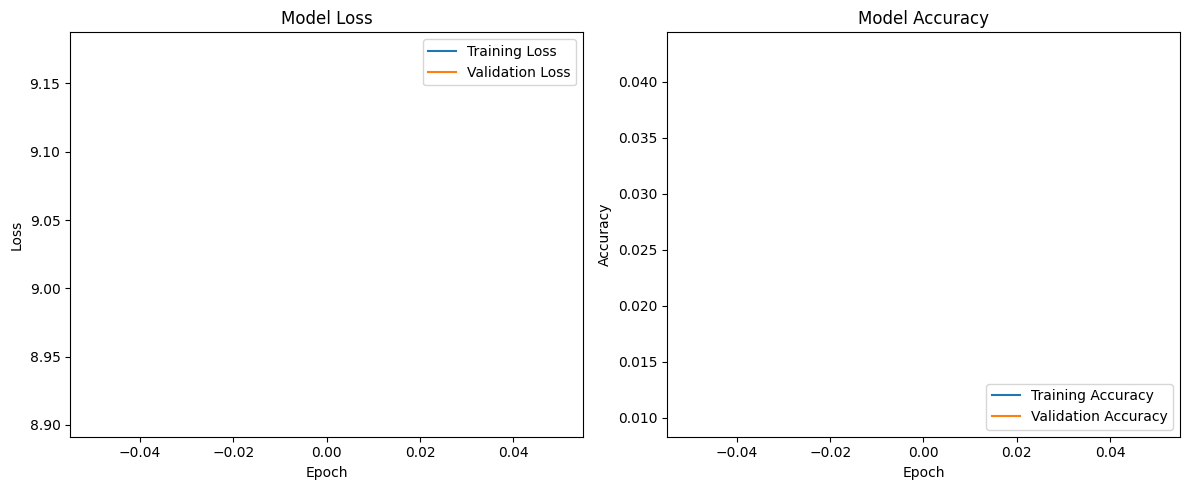

In [5]:
# Evalúa con el conjunto de prueba
base_accuracy = model_base.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {base_accuracy}")

model_base.plot(history_base)

# EJERCICIO 2

Entrena el mismo modelo, incorporando las instancias no etiquetadas de entrenamiento mediante la técnica de auto-aprendizaje. Opcionalmente, se ponderará cada instancia de entrada en función de su calidad (o certeza).

Responde a las siguientes preguntas:
1. ¿Qué parámetros has definido para el entrenamiento?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en el Ejercicio 1?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
# Función para crear modelos consistentes durante self-training
def create_model():
    return ConvModel(
        learning_rate=0.0005,  # Learning rate reducido para fine-tuning
        dropout_prob=0.25,     
        l2_lambda=0.005        
    )

# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train,
    y_train=y_train,  
    unlabeled_data=unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.85,             
    train_epochs=4,
    verbose=1
)


# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train,
    y_train=y_train,  
    unlabeled_data=unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.85,             
    train_epochs=1,
    verbose=1
)

# Evalúa el modelo final
final_accuracy = final_model.score(x_test, y_test)
print(f"Accuracy del modelo final con self-training: {final_accuracy}")
print(f"Mejora respecto al modelo base: {final_accuracy - base_accuracy:.4f}")

---
Como se han cambiado los datos los volvemos a llamar

In [ ]:
unlabeled_train, x_train, y_train, x_val, y_val, x_test, y_test, one_hot_train, one_hot_val, one_hot_test = DatasetProcess.load_dataset()

# EJERCICIO 3

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en dos pasos (primero el autoencoder, después el clasificador). La arquitectura del encoder debe ser exactamente la misma que la definida en los Ejercicios 1 y 2, a excepción del último bloque de capas.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los Ejercicios 1 y 2?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [7]:
autoencoder = TwoStepAutoEncoder(
                                input_shape=unlabeled_train[0].shape,
                                learning_rate=0.01,
                                l2_lambda=0.0005,
                                dropout_prob=0.1)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)


/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
TwoStepTraining(autoencoder=autoencoder, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=512,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - loss: 0.4320 - val_loss: 0.1101
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.0083 - loss: 6.9379 - val_accuracy: 0.0112 - val_loss: 3911.9341


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


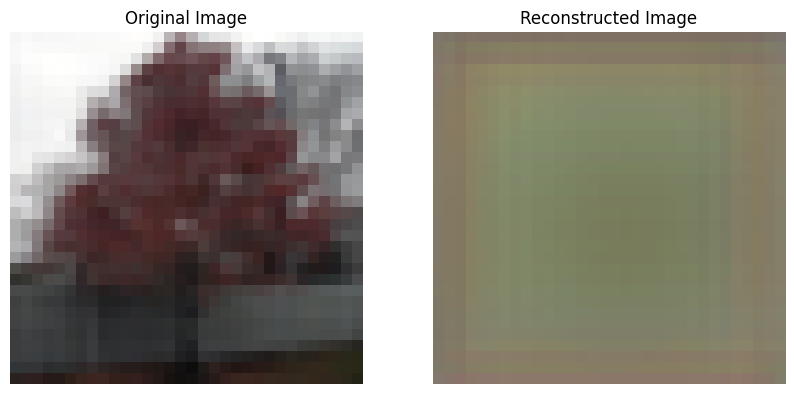

In [9]:
reconstruction_plot(autoencoder, x_test)

In [10]:
code = autoencoder.get_encoded_data(x_test)
test_accuracy = classifier.score(code, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0000e+00 - loss: 19073006.0000
Accuracy en conjunto de prueba: 0.0


# EJERCICIO 4

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en un paso (autoencoder y clasificador al mismo tiempo). La arquitectura del autoencoder será la misma que la definida en el Ejercicio 3, y la combinación de encoder y clasificador será igual a la arquitectura definida en el
Ejercicio 1.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los ejercicios anteriores?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [7]:
one_step_autoencoder = OneStepAutoencoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0035,
                                decoder_extra_loss_weight = 0.5,
                                l2_lambda=0.00005,
                                dropout_prob=0.05)

In [8]:
h = OneStepTraining(one_step_autoencoder, 
                    x_train=x_train, 
                    y_train=one_hot_train, 
                    unlabeled_train=unlabeled_train,
                    batch_size=512,
                    epochs=1,
                    patience=2)

82/82 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - classifier_accuracy: 0.0166 - classifier_loss: 0.9023 - decoder_loss: 0.0593 - loss: 0.6725


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


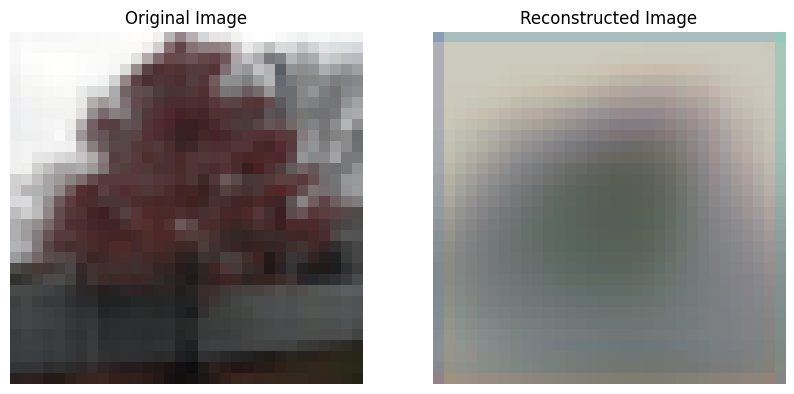

In [9]:
reconstruction_plot(one_step_autoencoder, x_test)

In [10]:
test_accuracy = one_step_autoencoder.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
Accuracy en conjunto de prueba: 0.0142
Mejora respecto al modelo base: 0.0041


# EJERCICIO 5

Repite el mismo entrenamiento de los Ejercicios 1-4, pero eliminando las instancias no etiquetadas
más atípicas con respecto a los datos etiquetados. Se cumplirán los siguientes puntos:
- La arquitectura de la red de clasificación en una clase será la misma a la utilizada en el
clasificador del Ejercicio 1, a excepción de la capa de salida.
- Utiliza la técnica explicada en el Notebook 5, usando un valor de 𝑣 = 0,9.

Responde a la siguiente pregunta:
1. ¿Se mejoran los resultados con respecto a los anteriores ejercicios? ¿Qué conclusiones sacas de estos resultados?

In [11]:
anomalyDetector = AnomalyDetector(input_shape=(32,32,3), 
                        nu=.9,
                        l2_lambda=0.0,
                        learning_rate=0.0001,
                        dropout_prob=0.0)
anomalyDetector.fit(x_train, 
          batch_size=256, 
          epochs=1, 
          delta=.025, 
          steps=100)

/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step- loss: 0.3621 
Cambiando r a 0.6848249 , max: 0.6980003 , min: 0.6745193
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 728ms/step - loss: 0.3596


<Sequential name=sequential_1, built=True>

In [12]:
filtered_unlabeled_train, is_typical = anomaly_report(anomalyDetector, unlabeled_train)

1047/1047 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step
Porcentaje de datos no etiquetados etiquetados como típicos: 90.22%
Porcentaje de datos no etiquetados etiquetados como atípicos: 9.78%
Datos originales no etiquetados: (33500, 32, 32, 3)
Datos filtrados no etiquetados (solo típicos): (30224, 32, 32, 3)
Se eliminaron 3276 muestras atípicas


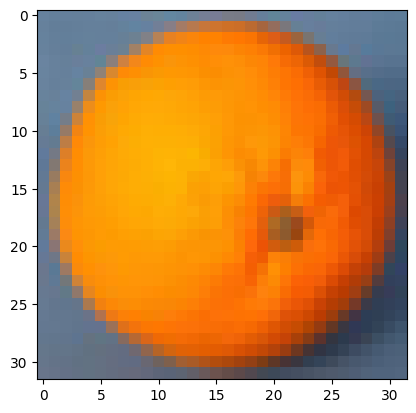

In [13]:
plot_atipicos(is_typical, unlabeled_train)

---
Ahora que tenemos los datos filtrados, repetimos

---

129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.0348 - loss: 17.0118 - val_accuracy: 0.0103 - val_loss: 11.2165
Restoring model weights from the end of the best epoch: 1.
Final model trained with 8250 samples


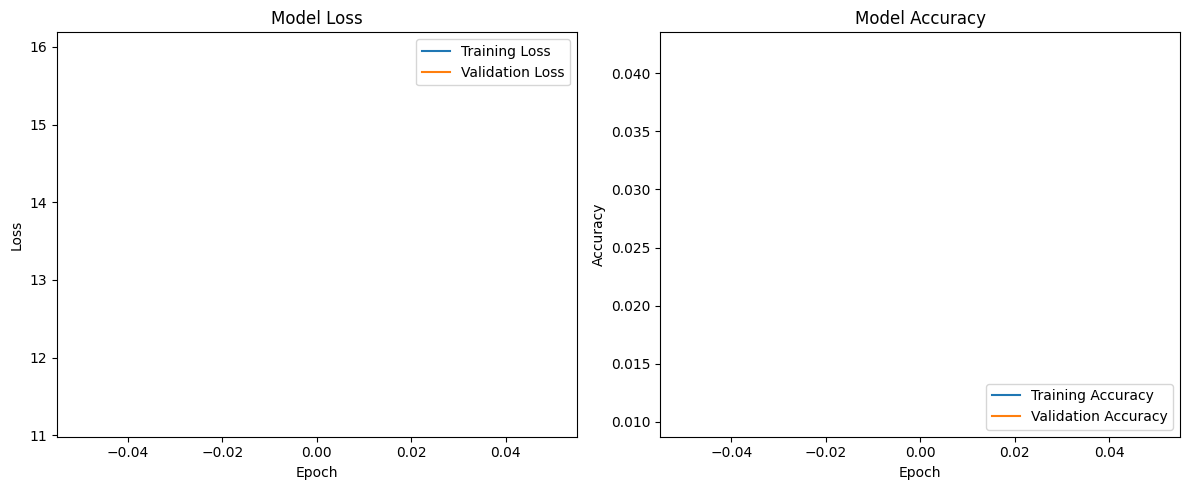

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0090 - loss: 11.2110
Accuracy en conjunto de prueba (self-training filtrado): 0.009999999776482582
Mejora respecto al modelo base: -0.0001


In [18]:
### Ejercicio 2 con datos filtrados
model_self_filtered = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train,
    y_train=y_train,
    unlabeled_data=filtered_unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.85,
    train_epochs=4
)

# Evaluar los modelos filtrados
test_accuracy_self_filtered = model_self_filtered.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba (self-training filtrado): {test_accuracy_self_filtered}")
print(f"Mejora respecto al modelo base: {test_accuracy_self_filtered - base_accuracy:.4f}")

/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - loss: 0.3200 - val_loss: 0.0975
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0152 - loss: 10.6840 - val_accuracy: 0.0109 - val_loss: 118.2977
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0000e+00 - loss: 563555.0000
Accuracy del modelo one-step filtrado: 0.0
Mejora respecto al modelo base: -0.0101
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


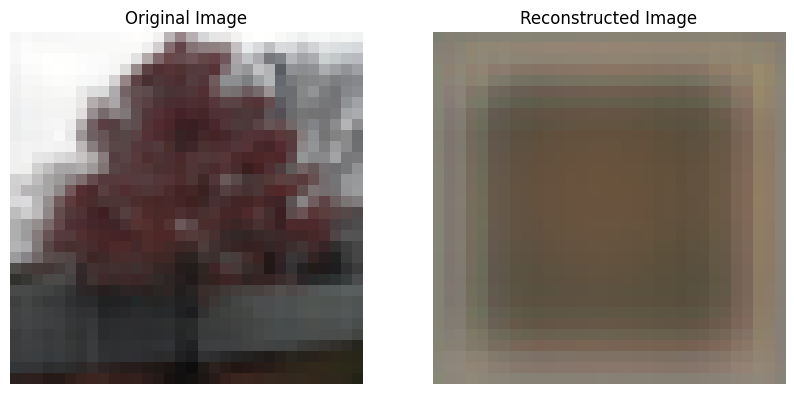

In [19]:
# Ejercicio 3 con datos filtrados
autoencoder_filtered = TwoStepAutoEncoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.006,
    l2_lambda=0.0005,
    dropout_prob=0.1
)

classifier_filtered = TwoStepClassifier(
    l2_lambda=0.0005,
    dropout_prob=0.05,
    learning_rate=0.05
)

history_two_step_filtered = TwoStepTraining(
    autoencoder=autoencoder_filtered, 
    classifier=classifier_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train, 
    validation_data=(x_val, one_hot_val),
    batch_size_autoencoder=256,
    epochs_autoencoder=1,
    batch_size_classifier=256,
    epochs_classifier=1
)

# Evaluar modelos

code = autoencoder_filtered.get_encoded_data(x_test)
test_accuracy = classifier_filtered.score(code, y_test)
print(f"Accuracy del modelo one-step filtrado: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

reconstruction_plot(autoencoder_filtered, x_test)

151/151 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - classifier_accuracy: 0.0203 - classifier_loss: 0.9907 - decoder_loss: 0.0550 - loss: 0.7363
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


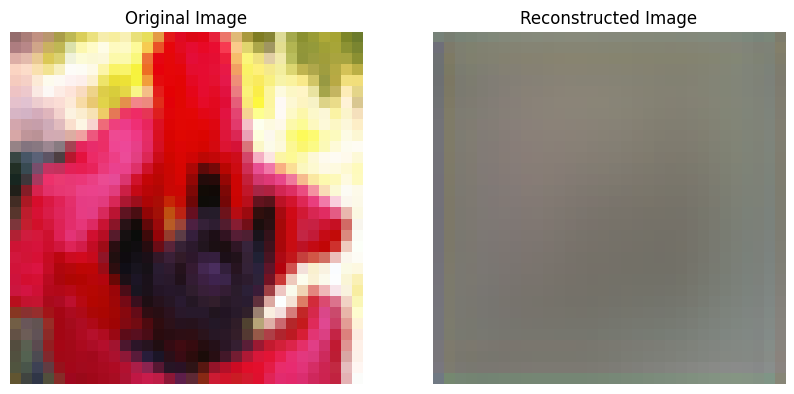

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
Accuracy del modelo one-step filtrado: 0.0159
Mejora respecto al modelo base: 0.0058


In [20]:
# Ejercicio 4 con datos filtrados
one_step_autoencoder_filtered = OneStepAutoencoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.0015,
    decoder_extra_loss_weight=0.45,
    l2_lambda=0.00005,
    dropout_prob=0.05
)

history_one_step_filtered = OneStepTraining(
    one_step_autoencoder_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train,
    batch_size=256,
    epochs=1,
    patience=10
)
# Evaluar modelos
reconstruction_plot(one_step_autoencoder_filtered, x_test)

test_accuracy_one_step_filtered = one_step_autoencoder_filtered.score(x_test, y_test)
print(f"Accuracy del modelo one-step filtrado: {test_accuracy_one_step_filtered}")
print(f"Mejora respecto al modelo base: {test_accuracy_one_step_filtered - base_accuracy:.4f}")

# EJERCICIO 6

Repite los Ejercicios 3-5 cambiando el autencoder por la técnica definida en el apartado “Hay vida más allá del autoencoder” del Notebook 4. Contesta a las preguntas de dichos ejercicios. Se cumplirán los siguientes puntos:

1. La arquitectura de la red será igual a la parte encoder del autencoder definido en los
ejercicios anteriores.
2. El modelo debe entrenar correctamente.

In [ ]:
# ejercicio 3 two step con todos los datos

cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.0001,
                          dropout_prob=0.005)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.01,
                               learning_rate=0.05)


In [ ]:
TwoStepTraining(autoencoder=cModel, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=1, 
                contrastive=True)

# Evaluar modelos

code = cModel.get_encoded_data(x_test)
test_accuracy = classifier.score(code, y_test)
print(f"Accuracy del modelo one-step filtrado: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

reconstruction_plot(autoencoder_filtered, x_test)

In [ ]:
# ejercicio 4 ONE STEP con todos los datos

cSSLModel = SemiSupervisedContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.15, 
                          lambda_param=.9,
                          l2_lambda=0.0001,
                          dropout_prob=0.001,
                          lambda_supervised=1.0)


cSSLModel.train(
    X_unlabeled=unlabeled_train,  
    X_labeled=x_train,        
    y_labeled=y_train,       
    epochs=1,
    batch_size=128
)

cSSLModel.plot_training_history()
test_accuracy = cSSLModel.score(x_test, y_test)
print(f"Accuracy del modelo one-step filtrado contrastivo con todos los datos: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")
reconstruction_plot(cSSLModel, x_test)
cSSLModel.confusion_matrix(x_test, y_test)

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cSSLModel.plot_similarity_matrix(test_samples, n_samples=n_samples)

---

In [ ]:
# ejercicio 3 two step con los datos filtrados

cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)

In [ ]:
TwoStepTraining(autoencoder=cModel, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=filtered_unlabeled_train, # <-
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=1, 
                contrastive=True)

In [ ]:
# Evaluacion ejercicio 3 two step con los datos filtrados

code = cModel.get_encoded_data(x_test)
test_accuracy = classifier.score(code, y_test)
print(f"Accuracy del modelo two-step filtrado: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

reconstruction_plot(cModel, x_test)

In [ ]:
# ejercicio 4 ONE STEP con los datos filtrados

cSSLModel = SemiSupervisedContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001,
                          lambda_supervised=1.0)


cSSLModel.train(
    X_unlabeled=filtered_unlabeled_train,  
    X_labeled=x_train,        
    y_labeled=y_train,       
    epochs=1,
    batch_size=128
)



cSSLModel.plot_training_history()


test_accuracy = cSSLModel.score(x_test, y_test)
print(f"Accuracy del modelo one-step filtrado contrastivo con datos filtrados: {test_accuracy}")
print(f"Mejora respecto al modelo base: {test_accuracy - base_accuracy:.4f}")

reconstruction_plot(cSSLModel, x_test)

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cSSLModel.plot_similarity_matrix(test_samples, n_samples=n_samples)